<a href="https://colab.research.google.com/github/eghove/week4-health-2/blob/master/Week4_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 Homework for Siraj Raval's *Make Money With Machine Learning* Course

## Objectives


*   Retrain the 'inception v3' image classifier on the pneumonia dataset using TensorFlow and Keras
  * More information on inception v3 may be found here: https://keras.io/applications/#inceptionv3
  * The dataset in question may be found on Kaggle here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
*   Create a Jupyter notebook that shows:
  * The training process, and
  * 2 examples of it making predictions on images from the testing dataset.
* Use this repository from GitHub User anjanatiha for inspiration: https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning



## The Code

### Getting Access to Google Drive

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Data

In [0]:
# import some of the initial dependenies used
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# use OS to reach out to the Kaggle API to get the dataset

os.environ['KAGGLE_USERNAME'] = "" 
os.environ['KAGGLE_KEY'] = "" 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia  --force

100% 1.15G/1.15G [00:06<00:00, 158MB/s]
100% 1.15G/1.15G [00:06<00:00, 178MB/s]


In [0]:
# unzip the data

# dependency to unzip the data
from zipfile import ZipFile

zf = ZipFile('chest-xray-pneumonia.zip', 'r')
zf.extractall()
zf.close()


In [15]:
# See what's in our file directory
ls

chest-xray-pneumonia.zip  chest_xray.zip  drive/  sample_data/


In [0]:
# unzip again this time the chest_xray.zip
zf = ZipFile('chest_xray.zip', 'r')
zf.extractall()
zf.close()

In [17]:
# See what's in our file directory, the chest_xray folder is what I care about
ls

chest_xray/               chest_xray.zip  __MACOSX/
chest-xray-pneumonia.zip  drive/          sample_data/


In [18]:
# see what's inside that chest_xray folder. Three folders containing test data, training data, and validation data
ls chest_xray/

test/  train/  val/


In [22]:
# take a peek at what's inside each of these folders
!ls chest_xray/test/
!ls chest_xray/train/
!ls chest_xray/val/

NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [0]:
# let's set up the file paths where the data lives
from pathlib import Path

train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"
validation_files = "./chest_xray/val/"

# the two classes we care about
positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"

### Looking at Our Data

In [25]:
# training files

# number of X-RAYS which show Pneumonia
P = Path(train_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(train_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))

Training-Pneumonia - 3875 
Training-Normal - 1341 


In [27]:
# validation files

# testing files

# number of X-RAYS which show Pneumonia
P = Path(validation_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Validation-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(validation_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Validation-Normal - %i " % len(temp))

Validation-Pneumonia - 8 
Validation-Normal - 8 


In [26]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(test_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(test_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

Testing-Pneumonia - 390 
Testing-Normal - 234 


### Preprocessing our Data

In [0]:
# using ImageDataGenerator to skew up the training data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(featurewise_center = True,
                                     shear_range = 0.2, #messes up the image a little so we don't train on perfect looking data
                                     rescale = 1.0/255, #maximum value is 255, scale it all so our NN has a better time training
                                     horizontal_flip = True, #also messes up our data little
                                     validation_split = 0) #zeroed this out since we don't need to split out validation here since we already have some validation data

test_generator = ImageDataGenerator(rescale = 1.0/255)

In [71]:
train_iterator = train_generator.flow_from_directory(train_files, 
                                                     target_size = (150, 150),
                                                     classes = [positive_class_folder_name, negative_class_folder_name],
                                                     batch_size = 256, 
                                                     shuffle = True, 
                                                     class_mode = "binary",
                                                     subset = "training")

## different from the example I'm reading through
validation_iterator = test_generator.flow_from_directory(validation_files, 
                                                      target_size = (150, 150),
                                                      classes = [positive_class_folder_name, negative_class_folder_name],
                                                      batch_size = 128, 
                                                      shuffle = False, 
                                                      class_mode = "binary",)
## different from the example I'm reading through

test_iterator = test_generator.flow_from_directory(test_files, 
                                                   target_size = (150, 150), 
                                                   classes = [positive_class_folder_name, negative_class_folder_name],
                                                   batch_size = 64, 
                                                   shuffle = False,
                                                   class_mode = "binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [33]:
# count for class instances in training data

class1 = sum(train_iterator.classes)
class0 = len(train_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

Label 0 - 3875, Label 1 - 1341


In [34]:
# count for class instances in validation data

class1 = sum(validation_iterator.classes)
class0 = len(validation_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

Label 0 - 8, Label 1 - 8



*   0 = Normal
*   1 = Pneumonia






### Transer Learning

In [0]:
# pull in some dependencies needed here
from tensorflow.keras.backend import clear_session
from IPython.display import clear_output

from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [74]:
clear_session()

base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
clear_output()

base_model.trainable = False
# building the model
myModel = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation = "relu"),
                      Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

myModel.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [76]:
history = myModel.fit_generator(train_iterator, 
                                steps_per_epoch = len(train_iterator),
                                epochs = 25,
                                verbose = 1,
                                workers = 20,
                                validation_data = validation_iterator, 
                                validation_steps = len(validation_iterator),
                                )

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 55s 3s/step - loss: 0.3292 - acc: 0.8696 - val_loss: 0.6322 - val_acc: 0.7500
Epoch 2/25
21/21 [==============================] - 53s 3s/step - loss: 0.3125 - acc: 0.8769 - val_loss: 1.3634 - val_acc: 0.6250
Epoch 3/25
21/21 [==============================] - 53s 3s/step - loss: 0.2963 - acc: 0.8758 - val_loss: 1.5996 - val_acc: 0.5625
Epoch 4/25
21/21 [==============================] - 53s 3s/step - loss: 0.2738 - acc: 0.8903 - val_loss: 1.1713 - val_acc: 0.6250
Epoch 5/25
21/21 [==============================] - 53s 3s/step - loss: 0.2499 - acc: 0.8947 - val_loss: 1.9726 - val_acc: 0.5000
Epoch 6/25
21/21 [==============================] - 52s 2s/step - loss: 0.2360 - acc: 0.8990 - val_loss: 0.6665 - val_acc: 0.6250
Epoch 7/25
21/21 [==============================] - 53s 3s/step - loss: 0.2355 - acc: 0.9020 - val_loss: 1.8032 - val_acc: 0.6250
Epoch 8/25
21/21 [==============================] - 53s 3s/step - loss: 0.2086 - acc: 0.9174 - val_lo

In [0]:
# save the model
save_model(myModel, "./myModel_after_25_epochs", overwrite = True, include_optimizer = True)

In [0]:
# load the model
myModel = load_model("./myModel_after_25_epochs")

### Evaluate the Model

In [80]:
from sklearn.metrics import classification_report


yhat = myModel.predict_generator(test_iterator,
                                 steps = len(test_iterator),
                                 verbose = 0)  
mask = yhat > 0.5
yhat[mask] = 1
yhat[~mask] = 0

# got to evaluate the model against the test data set now
y = test_iterator.classes

target_names = [positive_class_folder_name, negative_class_folder_name]
print(classification_report(y, yhat, target_names = target_names))

              precision    recall  f1-score   support

   PNEUMONIA       0.77      0.80      0.79       390
      NORMAL       0.65      0.60      0.62       234

    accuracy                           0.73       624
   macro avg       0.71      0.70      0.71       624
weighted avg       0.72      0.73      0.73       624



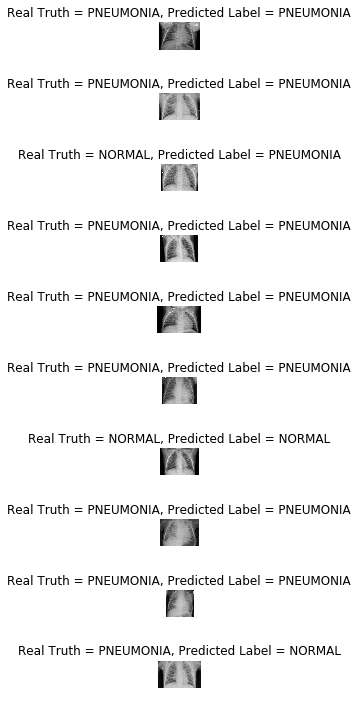

In [82]:
# visualize some predictions, going to look at 10 at a time
from random import randint
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

label_dict = {0:"PNEUMONIA", 1:"NORMAL"}

test_file_names = test_iterator.filenames
n = len(test_file_names)

plt.rcParams["figure.figsize"] = 12, 10

for i in range(10):
    index = randint(0, n - 1)
    file_name = test_files + test_file_names[index]
    
    image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ground_truth_label = label_dict[int(y[index])]
    predicted_label = label_dict[int(yhat[index])]
    
    plt.subplot(10, 1, i + 1)
    plt.axis("off")
    plt.imshow(image)
    
    title = "Real Truth = " + ground_truth_label + ", Predicted Label = " + predicted_label
    plt.title(title)

plt.tight_layout()
plt.show()